In [1]:
# imports
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import gridspec
from matplotlib.colorbar import Colorbar
import matplotlib.patches as mpatches
from matplotlib.ticker import FormatStrFormatter
%matplotlib inline
from matplotlib import cm
from skimage import measure

import spglib
import scipy.io
import os

from ipywidgets import widgets
import ipywidgets
from IPython.display import display

from crystex import projections, plots, lattice, coordgeometry, rotations,\
                    fileutils, misorientations, symmetry
from crystex.lattice import crystal2ortho, reciprocal_lattice_vecs

from vecmaths import rotation
import vecmaths.vectors as vec_ops


## Functions

In [2]:
def plot_pole_fig_paper(proj_poles, poles,  lattice_sys=None, axes='xyz',
                  grid=False, clrs=None, title=None,pole_lbl=None,
                  marker_size=0.005, proj_poles_theory=None, markers=None,
                       facecolors=None, cls = ['salmon',  'darkblue']):
    """
    Return a figure object for a pole figure. For a single crystal, plots a single 
    pole figure for all `poles`. For a poly crystal, plots n pole figures, one 
    for each pole in `poles`. 

    Parameters
    ----------
    proj_poles : tuple of ndarrays of shape (n,)
        Arrays of `n` polar angles and radii as projections of poles.
    poles : ndarray of shape (3, n)
        Specify poles to be plotted as column vectors.
    lattice_sys : string, optional
        Lattice system is one of cubic, hexagonal, rhombohedral, tetragonal, 
        orthorhombic, monoclinic, triclinic.
    axes  : string
        Set alignment of sample axes with projection sphere axes. Options:
        'xyz' (default); 'yzx'; 'zxy'; 'yxz'; 'zyx'; 'xzy'.
    grid : bool
        Turn grid lines on plot on or off (default).
    clrs : list of string
        A list of colours to plot `poles` in a single crystal.
    title: string
        Plot title
    proj_poles_theory : list of ndarrays of shape (2, n) or list of lists for multiple
        components
        Arrays of `n` polar angles and radii as projections of the theoretical poles.
    Returns
    -------
    f : matplotlib figure

    TODO:
    - Sort out plot labelling: based on lattice system for single crystal, and
        based on plotted pole for polycrystal.
    - Think about whether to have more than one pole figure for a single crystal 
    as well.
    - Add check the lenght of proj_poles = number of poles given.
    - Add label with plot details: phase, projection type, upper hemisphere, 
    data plotted.
    - Think about link between number of bins and angles.

    """
    # Check valid entry for axes alignment
    all_axes = ['xyz', 'yzx', 'zxy', 'yxz', 'zyx', 'xzy']
    if axes not in all_axes:
        raise ValueError('"{}" is not a valid axes option. '
                         '`axes` must be one of: {}.'.format(
                             axes, all_axes))


    n_figs = len(proj_poles)
    width_ratios = np.append([1] * n_figs, 0.1)
    # get poles labels
    poles_lbl = []
    for i in range(n_figs):
        poles_lbl.append(''.join([str(x) for x in poles[:, i]]))


    f_width = 3 * n_figs
    f_height = 10
    f = plt.figure(1, figsize=(f_width, f_height))
    gs0 = gridspec.GridSpec(1, 1)
    gs0.update(left=0.05, right=0.95, bottom=0.08, top=0.93, wspace=0.02, hspace=0.03)
    gs00 = gridspec.GridSpecFromSubplotSpec(1, n_figs+1, subplot_spec=gs0[0], width_ratios=width_ratios)
    

    if markers:
        m = markers
    else:
        m = ['o', 'x']
    if not facecolors:
        facecolors = ['#8b0000',  '#d95f02']
#     print('facecolors: ', facecolors)
#     cls = ['#8b0000',  '#d95f02']
    
    edgecolors = ['#8b0000',  'lilac']
    # Plot scatter pole figures
    for n in range(n_figs):
        ax = f.add_subplot(gs00[n], projection='polar')
        
        cax = ax.scatter(proj_poles[n][0],
                            proj_poles[n][1], c='#1b9e77', s=marker_size, marker='o')

        if proj_poles_theory is not None and len(proj_poles_theory)>=1:
            for p_i, proj_th in enumerate(proj_poles_theory):
#                 print(p_i)
#                 print(facecolors[p_i])
                cax = ax.scatter(proj_th[n][0],
                        proj_th[n][1], c=cls[p_i], s=15, marker=m[p_i],)
#                         facecolors=facecolors[p_i], edgecolors=edgecolors[p_i])
        elif proj_poles_theory is not None:
#             print(n)
            cax = ax.scatter(proj_poles_theory[n][0],
                        proj_poles_theory[n][1], c='salmon',  marker='o', s=20)

        ax.set_rmax(1)
        # Axes labels (X,Y,Z)
        # ax.set_xticklabels([axes[0].upper(), '', axes[1].upper(), '', '', '', '', ''])
        ax.set_xticklabels(['', '', '', '', '', '', '', ''])
        
        ax.set_yticklabels([])
        if type(pole_lbl)==list:
            ax.set_title(pole_lbl[n], fontsize=14)  # loc='left'
        
        if not grid:
            ax.yaxis.grid(False)
        xgridlines = ax.xaxis.get_gridlines()
        [grl.set_alpha(0) for grl in xgridlines[1::2]]

    return f
def plot_pole_fig_paper_tet(proj_poles, poles,  lattice_sys=None, axes='xyz',
                  grid=False, clrs=None, title=None, pole_lbl=None,
                  marker_size=0.005, proj_poles_theory=None, proj_pole_match=None):
    """
    Return a figure object for a pole figure. For a single crystal, plots a single 
    pole figure for all `poles`. For a poly crystal, plots n pole figures, one 
    for each pole in `poles`. 

    Parameters
    ----------
    proj_poles : tuple of ndarrays of shape (n,)
        Arrays of `n` polar angles and radii as projections of poles.
    poles : ndarray of shape (3, n)
        Specify poles to be plotted as column vectors.
    lattice_sys : string, optional
        Lattice system is one of cubic, hexagonal, rhombohedral, tetragonal, 
        orthorhombic, monoclinic, triclinic.
    axes  : string
        Set alignment of sample axes with projection sphere axes. Options:
        'xyz' (default); 'yzx'; 'zxy'; 'yxz'; 'zyx'; 'xzy'.
    grid : bool
        Turn grid lines on plot on or off (default).
    clrs : list of string
        A list of colours to plot `poles` in a single crystal.
    title: string
        Plot title
    proj_poles_theory : list of ndarrays of shape (2, n) or list of lists for multiple
        components
        Arrays of `n` polar angles and radii as projections of the theoretical poles.
    Returns
    -------
    f : matplotlib figure

    TODO:
    - Sort out plot labelling: based on lattice system for single crystal, and
        based on plotted pole for polycrystal.
    - Think about whether to have more than one pole figure for a single crystal 
    as well.
    - Add check the lenght of proj_poles = number of poles given.
    - Add label with plot details: phase, projection type, upper hemisphere, 
    data plotted.
    - Think about link between number of bins and angles.

    """
    # Check valid entry for axes alignment
    all_axes = ['xyz', 'yzx', 'zxy', 'yxz', 'zyx', 'xzy']
    if axes not in all_axes:
        raise ValueError('"{}" is not a valid axes option. '
                         '`axes` must be one of: {}.'.format(
                             axes, all_axes))


    n_figs = len(proj_poles)
    width_ratios = np.append([1] * n_figs, 0.1)
    # get poles labels
    poles_lbl = []
    for i in range(n_figs):
        poles_lbl.append(''.join([str(x) for x in poles[:, i]]))


    f_width = 3 * n_figs
    f_height = 10
    f = plt.figure(1, figsize=(f_width, f_height))
    gs0 = gridspec.GridSpec(1, 1)
    gs0.update(left=0.05, right=0.95, bottom=0.08, top=0.93, wspace=0.02, hspace=0.03)
    gs00 = gridspec.GridSpecFromSubplotSpec(1, n_figs+1, subplot_spec=gs0[0], width_ratios=width_ratios)

    m = ['o', 'x']
    cls = ['#8b0000',  '#d95f02']
    # Plot scatter pole figures
    for n in range(n_figs):
        ax = f.add_subplot(gs00[n], projection='polar')
        
        cax = ax.scatter(proj_poles[n][0],
                            proj_poles[n][1], c='#1b9e77', s=marker_size, marker='o')

        if proj_poles_theory is not None and len(proj_poles_theory)==2:
            for p_i, proj_th in enumerate(proj_poles_theory):
                cax = ax.scatter(proj_th[n][0],
                        proj_th[n][1], c=cls[p_i], s=20, marker=m[p_i])
        elif proj_poles_theory is not None:
            cax = ax.scatter(proj_poles_theory[n][0],
                        proj_poles_theory[n][1], cmap=cm.hsv,  marker='v')
        
        if n == 1:
            print(n)
            cax = ax.scatter(proj_pole_match[0],
                            proj_pole_match[1], s=5, marker='o',
                            facecolors='none', edgecolors='#191970')
        
        ax.set_rmax(1)
        # Axes labels (X,Y,Z)
        # ax.set_xticklabels([axes[0].upper(), '', axes[1].upper(), '', '', '', '', ''])
        ax.set_xticklabels(['', '', '', '', '', '', '', ''])
        
        ax.set_yticklabels([])
        if type(pole_lbl)==list:
            ax.set_title(pole_lbl[n], fontsize=12)  # loc='left'
        
        if not grid:
            ax.yaxis.grid(False)
        
        xgridlines = ax.xaxis.get_gridlines()
        [grl.set_alpha(0) for grl in xgridlines[1::2]]

    return f

# EBSD

This notebook presents code for exploring the EBSD and SPED orientation data for metal grain 1 and oxide region 1, and also for calculating the theoretical orientation relationships between the crystallographic phases.  

## Metal Zr

### Load experimental data

In [43]:
pole_type = 'plane-normal' # 'direction' / 'plane-normal'
proj_type='equal_area'  # 'stereographic' / 'equal-area' 
align='cz'          
hcp_sym_ops = symmetry.SYM_OPS['6/mmm']



In [44]:
# USER INPUT: Input file path-------------------------------------------------
home_path = './data/'
file_path = r'EBSD_metal_grain_1.ctf'
# ----------------------------------------------------------------------------

tw = widgets.ToggleButtons(
    description='Technique:',
    options=['ASTAR', 'EBSD'],
)
display(tw)

ToggleButtons(description='Technique:', options=('ASTAR', 'EBSD'), value='ASTAR')

In [45]:
# Read data
header = fileutils.read_ctf_header(os.path.join(home_path, file_path), )
n_ph = header['no_phases']

data = pd.read_csv(os.path.join(home_path, file_path), sep='\t', header=13 + n_ph).values

XCells = header['XCells']
YCells = header['YCells']
num_pix = XCells * YCells

idx_rows = np.tile(np.arange(XCells), YCells)
idx_cols = np.repeat(np.arange(YCells), XCells)

phases = data[:,0].astype(int)
phases -= 1
euler_angles = data[:,5:8]
mad = data[:,8]
bc = data[:,9]
bs = data[:,10]

phase_map = phases.reshape((XCells,YCells), order = 'F')

eul_map = euler_angles.reshape((XCells,YCells, 3), order = 'F')
eul_map_norm = np.copy(eul_map)
eul_map_norm[:,:,0] /= 360.0
eul_map_norm[:,:,1] /= 180.0
eul_map_norm[:,:,2] = coordgeometry.wrap_angles(eul_map_norm[:,:,2], 0.0, 360.0)
eul_map_norm[:,:,2] /= 360.0

mad_map = mad.reshape((XCells,YCells), order = 'F')
bc_map = bc.reshape((XCells,YCells), order = 'F')
bs_map = bs.reshape((XCells,YCells), order = 'F')

# Map options based on technique
map_opt = []
tech = tw.value # technique type
if tech == 'EBSD':
    map_opt.append('band contrast')
    map_opt.append('mean angular deviation')
    
else:
    map_opt.append('intensity')
    map_opt.append('reliability factor')
map_opt.append('phases')
map_opt.append('euler angles')

In [46]:
print('Total number of pixels: ', num_pix)
print(header['phases'][0]['name'], np.sum(phases == 0))
print(header['phases'][1]['name'], np.sum(phases == 1))
print(header['phases'][2]['name'], np.sum(phases == 2))
print('Non-indexed', np.sum(phases == -1))

Total number of pixels:  160000
Zirconia tetragonal 10
Zirc-alloy4 9828
Zr02 monoclinic 4
Non-indexed 150158


### Plot experimental pole figures

In [47]:
ph_opt = [x['name'] for x in header['phases']]
all_ph_ind = [index+1 for index, value in enumerate(ph_opt)]

style = {'description_width': 'initial'}
w = widgets.RadioButtons(
    description='Choose a phase',
    options=ph_opt,
    layout=ipywidgets.Layout(width='100%', height='80px'),
    style=style,
    index=1
)
display(w)

RadioButtons(description='Choose a phase', index=1, layout=Layout(height='80px', width='100%'), options=('Zirc…

In [48]:
# Phase index, name and lattice parameters
ph_ind = ph_opt.index(w.value)
ph_name = w.value
ph_params = header['phases'][ph_ind]['lattice_params']

# Create masks to be used for plotting the right data
mask_1d = phases != ph_ind
mask_2d = np.repeat(mask_1d[:,np.newaxis], 2, axis=1)
mask_3d = np.repeat(mask_1d[:,np.newaxis], 3, axis=1)

print('Chosen phase: ')
print(header['phases'][ph_ind])

Chosen phase: 
{'name': 'Zirc-alloy4', 'lattice_params': [3.231, 3.231, 5.148, 90.0, 90.0, 120.0]}


In [49]:
# USER INPUT: Pole figure options---------------------------------------------
lattice_system = 'hexagonal'
poles = np.array([[1,-1,0,0], [1,1,-2,0],[0,0,0,1], [1,1,-2,4]]).T
poles = np.array([[1,-1,0,0], [1,1,-2,0],[0,0,0,1], [1,0,-1,2]]).T
proj_type = 'equal_area'   # 'stereographic' or 'equal_area'
plot_contour = False        # True or False
axes = 'zyx'                #'zyx' 'xyz' (default); 'yzx'; 'zxy'; 'yxz'; 'zyx'; 'xzy'
# ----------------------------------------------------------------------------


In [50]:
latt_params_hcp = ph_params  #a, b, c, α, β, γ

#------------------------------------------------------

params_dict_hcp = {
    'a': latt_params_hcp[0],
    'b': latt_params_hcp[1],
    'c': latt_params_hcp[2],
    'α': latt_params_hcp[3],
    'β': latt_params_hcp[4],
    'γ': latt_params_hcp[5]}
M_hcp = lattice.crystal2ortho(lattice_system, **params_dict_hcp, normed=False,
                                  degrees=True, align='cz')
cell_e = np.eye(3)
cell_ortho_hcp = np.dot(M_hcp.T, cell_e)
cell_rec_hcp = lattice.reciprocal_lattice_vecs(cell_ortho_hcp)

C:\Users\maria\anaconda3\envs\crystex_env\lib\site-packages\ipykernel_launcher.py:102: UserWarning:

FixedFormatter should only be used together with FixedLocator



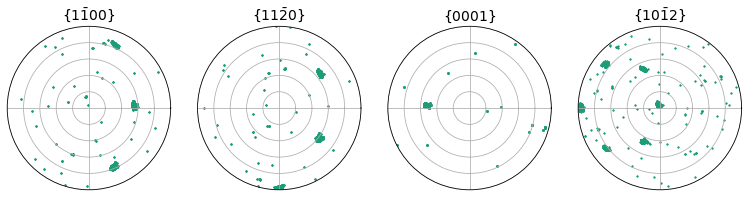

In [51]:
#  code
eulers_m = np.ma.compress_rowcols(np.ma.array(euler_angles, 
                                              mask=mask_3d), 0)

rot_mat_m = np.linalg.inv(
                rotations.euler2rot_mat_n(eulers_m, degrees=True))

proj_poles = projections.project_crystal_poles(poles, 
                                               eulers=eulers_m,
                                               crys='poly', 
                                               proj_type=proj_type, 
                                               lattice_sys=lattice_system, 
                                               latt_params=ph_params,
                                               pole_type='plane-normal', 
                                               degrees=True, axes=axes,
                                               apply_sym=True)


pole_lbl = [r'{$1\bar{1}00$}', r'{$11\bar{2}0$}', r'{$0001$}', r'{$10\bar{1}2$}']


fig = plot_pole_fig_paper(proj_poles, poles=poles, 
                          pole_lbl=pole_lbl,
                          lattice_sys=lattice_system, axes=axes, 
                         marker_size=1, grid=True)
plt.show(fig)

### Calculate mean metal orientation

In [52]:
# inverse matrix needed
r_met = np.linalg.inv(rotations.euler2rot_mat_n(np.mean(eulers_m, axis=0)[None], degrees=True))
# rt = rotations.ax_ang2rot_mat(np.array([0,0,1]), 180, degrees=True)
r_met_inv = np.linalg.inv(r_met)


C:\Users\maria\anaconda3\envs\crystex_env\lib\site-packages\ipykernel_launcher.py:102: UserWarning:

FixedFormatter should only be used together with FixedLocator



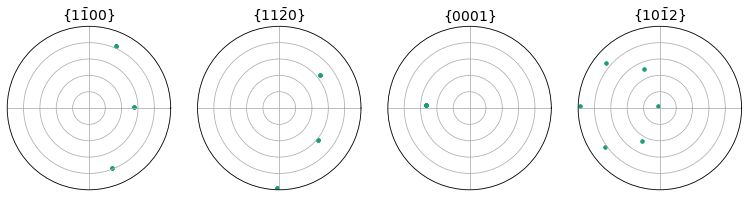

In [53]:
met_poles = projections.project_crystal_poles(poles, 
                                              rot_mat=r_met,
                                               crys='poly', 
                                               proj_type=proj_type, 
                                               lattice_sys='hexagonal', 
                                               latt_params=latt_params_hcp,
                                               pole_type='plane-normal', 
                                               degrees=True, axes=axes, 
                                               apply_sym=True,
                                              ret_poles=True)



met_poles_1124 = met_poles[1][-1]
proj_met_poles_1124 = met_poles[0][3]


# Plot pole figures
fig = plot_pole_fig_paper( met_poles[0], poles=poles, pole_lbl=pole_lbl,
                          lattice_sys=lattice_system, axes=axes, 
                        marker_size=10, grid=True)

plt.show(fig)

## Tetragonal  $\mathrm{ZrO}_2$

### BCT lattice parameters 

In [54]:
# -----Required parameters-----------------------------
lattice_system = 'tetragonal'
latt_params_tzro2 = [3.6055, 3.6055, 5.1797, 90.0, 90.0, 90.0]  #a, b, c, α, β, γ
#------------------------------------------------------

params_dict_tzro2 = {'a': latt_params_tzro2[0],
                     'b': latt_params_tzro2[1],
                     'c': latt_params_tzro2[2],
                     'α': latt_params_tzro2[3],
                     'β': latt_params_tzro2[4],
                     'γ': latt_params_tzro2[5]}
M_tet = lattice.crystal2ortho( **params_dict_tzro2, normed=False,
                                  degrees=True, align='cz')

tet_latt_vecs = lattice.crystal2ortho( **params_dict_tzro2, normed=False,
                                  degrees=True, align='cz').T

cell_e = np.eye(3)
cell_ortho_t = np.dot(M_tet.T, cell_e)
cell_rec_t = lattice.reciprocal_lattice_vecs(cell_ortho_t)

tet_sym_ops = symmetry.SYM_OPS['tetragonal']

### FCT lattice parameters

In [55]:
# -----Required parameters-----------------------------
latt_params_fctzro2 = [np.sqrt(2)*3.6055, np.sqrt(2)*3.6055,
                       5.1797, 90.0, 90.0, 90.0] #a, b, c, α, β, γ

#------------------------------------------------------

params_dict_fctzro2 = {'a': latt_params_fctzro2[0],
                       'b': latt_params_fctzro2[1],
                       'c': latt_params_fctzro2[2],
                       'α': latt_params_fctzro2[3],
                       'β': latt_params_fctzro2[4],
                       'γ': latt_params_fctzro2[5]}
M_fct = lattice.crystal2ortho('tetragonal', **params_dict_fctzro2, normed=False,
                                  degrees=True, align='cz')

fct_latt_vecs = lattice.crystal2ortho('tetragonal', **params_dict_fctzro2, normed=False,
                                  degrees=True, align='cz').T
cell_e = np.eye(3)
cell_ortho_fct = np.dot(M_fct.T, cell_e)
cell_rec_fct = lattice.reciprocal_lattice_vecs(cell_ortho_fct)

### Load experimental data

In [56]:
# USER INPUT: Input file path-------------------------------------------------
home_path = './data/'
file_path = 'EBSD_oxide_region_1.ctf'
# ----------------------------------------------------------------------------

tw = widgets.ToggleButtons(
    description='Technique:',
    options=['ASTAR', 'EBSD'],
)
display(tw)

ToggleButtons(description='Technique:', options=('ASTAR', 'EBSD'), value='ASTAR')

In [57]:
# Read data
header = fileutils.read_ctf_header(os.path.join(home_path, file_path), )
n_ph = header['no_phases']

data = pd.read_csv(os.path.join(home_path, file_path), sep='\t', header=13 + n_ph).values

XCells = header['XCells']
YCells = header['YCells']
num_pix = XCells * YCells

idx_rows = np.tile(np.arange(XCells), YCells)
idx_cols = np.repeat(np.arange(YCells), XCells)

phases = data[:,0].astype(int)
phases -= 1
euler_angles = data[:,5:8]
mad = data[:,8]
bc = data[:,9]
bs = data[:,10]

phase_map = phases.reshape((XCells,YCells), order = 'F')

eul_map = euler_angles.reshape((XCells,YCells, 3), order = 'F')
eul_map_norm = np.copy(eul_map)
eul_map_norm[:,:,0] /= 360.0
eul_map_norm[:,:,1] /= 180.0
eul_map_norm[:,:,2] = coordgeometry.wrap_angles(eul_map_norm[:,:,2], 0.0, 360.0)
eul_map_norm[:,:,2] /= 360.0

mad_map = mad.reshape((XCells,YCells), order = 'F')
bc_map = bc.reshape((XCells,YCells), order = 'F')
bs_map = bs.reshape((XCells,YCells), order = 'F')

# Map options based on technique
map_opt = ['phases','euler angles']
tech = tw.value # technique type
if tech == 'EBSD':
    map_opt.append('mean angular deviation')
    map_opt.append('band contrast')
else:
    map_opt.append('reliability factor')
    map_opt.append('intensity')

In [58]:
print('Total number of pixels: ', num_pix)
print(header['phases'][0]['name'], np.sum(phases == 0))
print(header['phases'][1]['name'], np.sum(phases == 1))
print(header['phases'][2]['name'], np.sum(phases == 2))
print('Non-indexed', np.sum(phases == -1))

Total number of pixels:  558700
Zirconia tetragonal 1847
Zirc-alloy4 1353
Zr02 monoclinic 49938
Non-indexed 505562


In [59]:
# CHOOSE PHASE
ph_opt = [x['name'] for x in header['phases']]
all_ph_ind = [index+1 for index, value in enumerate(ph_opt)]

style = {'description_width': 'initial'}
w = widgets.RadioButtons(
    description='Choose a phase',
    options=ph_opt,
    layout=ipywidgets.Layout(width='100%', height='80px'),
    style=style
)
display(w)

RadioButtons(description='Choose a phase', layout=Layout(height='80px', width='100%'), options=('Zirconia tetr…

In [60]:
# Phase index, name and lattice parameters
ph_ind = ph_opt.index(w.value)
ph_name = w.value
ph_params = header['phases'][ph_ind]['lattice_params']

# Create masks to be used for plotting the right data
mask_1d = phases != ph_ind
mask_2d = np.repeat(mask_1d[:,np.newaxis], 2, axis=1)
mask_3d = np.repeat(mask_1d[:,np.newaxis], 3, axis=1)

print('Chosen phase: ')
print(header['phases'][ph_ind])

Chosen phase: 
{'name': 'Zirconia tetragonal', 'lattice_params': [3.6055, 3.6055, 5.1797, 90.0, 90.0, 90.0]}


### Plot experimental pole figures

In [61]:
# USER INPUT: Pole figure options---------------------------------------------
lattice_system = 'tetragonal'
poles = np.array([[1,1,1], [1,0,0],[0,1,0],[0,0,1],[1,0,-3], [1,0,-6],[-6,0,1],[1,0,1], ]).T
poles = np.array([[1,1,-2],[1,1,1], [1,0,0],[0,1,0],[0,0,1], [1,1,-12],[1,0,1], ]).T
poles = np.array([[1,0,1],[0,0,1], [1,1,-12],[1,1,-2]]).T
# poles = np.array([[1,1,1],[0,0,1],[1,1,-2], [1,0,-6],[-6,0,1] ]).T
# poles = np.array([[1,0,1],[0,0,1], [1,0,-6],[1,0,-3], [1,1,-2],[3,1,-2]]).T
proj_type = 'equal_area'   # 'stereographic' or 'equal_area'
plot_contour = False        # True or False
axes = 'xyz'                # 'xyz' (default); 'yzx'; 'zxy'; 'yxz'; 'zyx'; 'xzy'
# ----------------------------------------------------------------------------



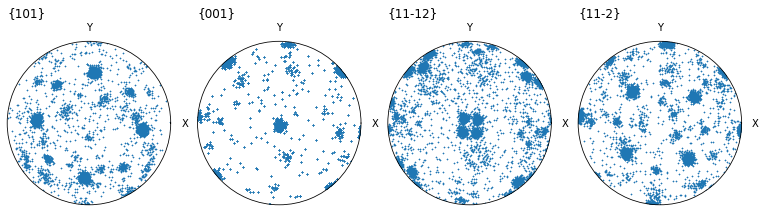

In [62]:
# code
eulers_m = np.ma.compress_rowcols(np.ma.array(euler_angles, 
                                              mask=mask_3d), 0)
rot_mat_m = np.linalg.inv(
                rotations.euler2rot_mat_n(eulers_m, degrees=True))


# Find projections of poles
proj_poles, poles_r = projections.project_crystal_poles(poles, 
#                                                eulers=eulers_m,
                                               rot_mat=rot_mat_m,
                                               crys='poly', 
                                               proj_type=proj_type, 
                                               lattice_sys='tetragonal',
                                               latt_params=latt_params_tzro2,
                                               pole_type='plane-normal', 
                                               degrees=True, axes=axes,
                                              apply_sym=True, ret_poles=True)

    
# Plot pole figures
fig = plots.plot_pole_fig(proj_poles, poles=poles, 
                          lattice_sys=lattice_system, crys='poly', axes=axes, 
                          contour=False, bins = 90, marker_size=0.1)

plt.show(fig)

### Find equivalent fct -> bct

In [63]:
poles = np.array([
    [1, 0, -6], 
    [1, 1, 1],
    [1, 1, -2],
    [3, 1, -2],
]).T

# Plane normal in bct Cartesian coordinates
n_plane_fct = np.dot(cell_rec_fct, poles)

# Rotation between bct and fct
rbct_fct = rotations.ax_ang2rot_mat( np.array([[0,0,1]]), -45, degrees=True)[0]
print('rbct_fct: \n', rbct_fct)

# Rotate normal
n_plane_fct_rot = rbct_fct @ n_plane_fct
print('n_plane_fct_rot: \n', n_plane_fct_rot)
# Convert to plane in bct
poles_bct = lattice.plane_from_normal(n_plane_fct_rot, latt_sys='tetragonal',
                                     latt_params=latt_params_tzro2, degrees=True)
poles_bct = np.cast[int](poles_bct)
print('poles_bct: \n ',poles_bct)


rbct_fct: 
 [[ 0.70710678  0.70710678  0.        ]
 [-0.70710678  0.70710678  0.        ]
 [ 0.          0.          1.        ]]
n_plane_fct_rot: 
 [[ 0.13867702  0.27735404  0.27735404  0.55470808]
 [-0.13867702  0.          0.         -0.27735404]
 [-1.15836825  0.19306137 -0.38612275 -0.38612275]]
poles_bct: 
  [[ 0  1  1  2]
 [ 0  0  0 -1]
 [-5  0 -1 -1]]


### Find equivalent poles bct-> fct

In [64]:
poles = np.array([[1,1,-2],[1,1,1], [1,0,0],[0,1,0],[0,0,1], [1,1,-12],[1,0,1], [-2,1,1]]).T

# Plane normal in bct Cartesian coordinates
n_plane_bct = np.dot(cell_rec_t, poles)
# Rotation between bct and fct
rbct_fct = rotations.ax_ang2rot_mat( np.array([[0,0,1]]), -45, degrees=True)[0]
print('rbct_fct: \n', rbct_fct)

# Rotate normal
n_plane_bct_rot = rbct_fct @ n_plane_bct
print('n_plane_bct_rot: \n', n_plane_bct_rot)
# Convert to plane in fct
poles_fct = lattice.plane_from_normal(n_plane_bct_rot, latt_sys='tetragonal',
                                     latt_params=latt_params_fctzro2, degrees=True)
poles_fct = np.cast[int](poles_fct)
print('poles_fct: \n', poles_fct)

rbct_fct: 
 [[ 0.70710678  0.70710678  0.        ]
 [-0.70710678  0.70710678  0.        ]
 [ 0.          0.          1.        ]]
n_plane_bct_rot: 
 [[ 0.39223785  0.39223785  0.19611892  0.19611892  0.          0.39223785
   0.19611892 -0.19611892]
 [ 0.          0.         -0.19611892  0.19611892  0.          0.
  -0.19611892  0.58835677]
 [-0.38612275  0.19306137  0.          0.          0.19306137 -2.31673649
   0.19306137  0.19306137]]
poles_fct: 
 [[  2   2   1   1   0   2   1  -1]
 [  0   0  -1   1   0   0  -1   3]
 [ -2   1   0   0   1 -12   1   1]]


### Plot FCT pole figures

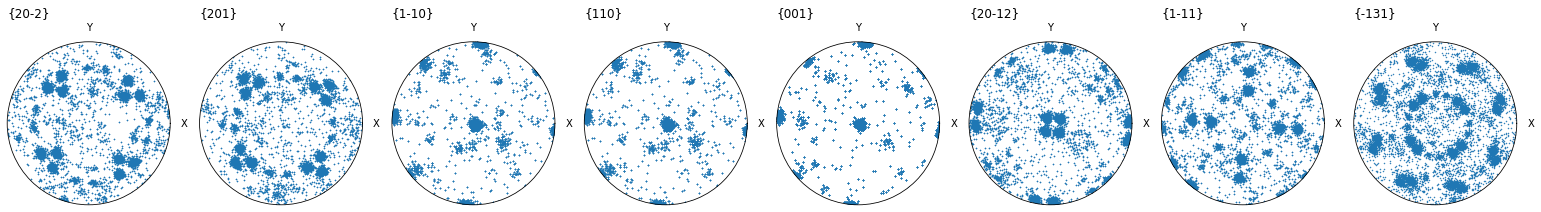

In [65]:
# plot fct
rbct_fct = rotations.ax_ang2rot_mat( np.array([[0,0,1]]), 45, degrees=True)[0]

eulers_m = np.ma.compress_rowcols(np.ma.array(euler_angles, 
                                              mask=mask_3d), 0)
rot_mat_m = np.linalg.inv(
                rotations.euler2rot_mat_n(eulers_m, degrees=True))


# Find projections of poles
proj_poles, poles_r = projections.project_crystal_poles(poles_fct, 
#                                                eulers=eulers_m,
                                               rot_mat=rbct_fct@rot_mat_m,
                                               crys='poly', 
                                               proj_type=proj_type, 
                                               lattice_sys='tetragonal',
                                               latt_params=latt_params_fctzro2,
                                               pole_type='plane-normal', 
                                               degrees=True, axes=axes,
                                              apply_sym=True, ret_poles=True)
proj_poles_masked = []
for n in range(len(proj_poles)):
    ang_masked = proj_poles[n][0]
    rad_masked = proj_poles[n][1]
    proj_poles_masked.append([ang_masked, rad_masked])
    
# Plot pole figures
fig = plots.plot_pole_fig(proj_poles, poles=poles_fct, 
                          lattice_sys=lattice_system, crys='poly', axes=axes, 
                          contour=False, bins = 90, marker_size=0.1)

plt.show(fig)
# fig.savefig('./plots/' + file_path[:-4] + '_mon-pole-fig.png', transparent=True, 
#           frameon=False, bbox_inches='tight', pad_inches=0)

### Apply inverse metal rotation

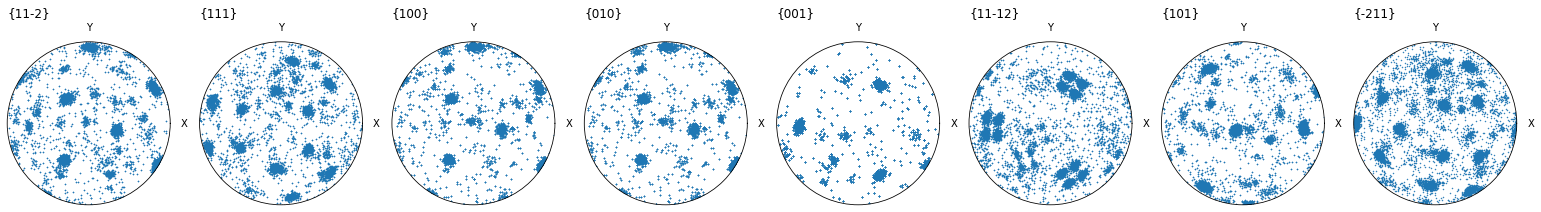

In [66]:
# code
eulers_m = np.ma.compress_rowcols(np.ma.array(euler_angles, 
                                              mask=mask_3d), 0)
rot_mat_m = np.linalg.inv(
                rotations.euler2rot_mat_n(eulers_m, degrees=True))


# Find projections of poles
proj_poles, poles_r = projections.project_crystal_poles(poles, 
#                                                eulers=eulers_m,
                                               rot_mat=r_met_inv@rot_mat_m,
                                               crys='poly', 
                                               proj_type=proj_type, 
                                               lattice_sys='tetragonal',
                                               latt_params=latt_params_tzro2,
                                               pole_type='plane-normal', 
                                               degrees=True, axes=axes,
                                              apply_sym=True, ret_poles=True)
proj_poles_masked = []
for n in range(len(proj_poles)):
    ang_masked = proj_poles[n][0]
    rad_masked = proj_poles[n][1]
    proj_poles_masked.append([ang_masked, rad_masked])
    
# Plot pole figures
fig = plots.plot_pole_fig(proj_poles, poles=poles, 
                          lattice_sys=lattice_system, crys='poly', axes=axes, 
                          contour=False, bins = 90, marker_size=0.1)

plt.show(fig)
# fig.savefig('./plots/' + file_path[:-4] + '_mon-pole-fig.png', transparent=True, 
#           frameon=False, bbox_inches='tight', pad_inches=0)

### Apply half of hcp symmetry operators

Rotation angle:  180


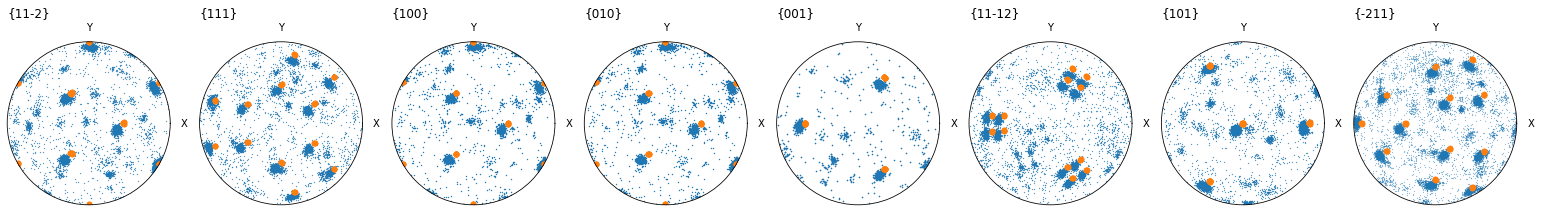

In [67]:
# Code plane
tettex_fct = np.array([[1, 0, -2]]).T
tettex_fct_p = cell_rec_fct @ tettex_fct

proj_poles, poles_r = projections.project_crystal_poles(poles, 
#                                                eulers=eulers_m,
                                               rot_mat=r_met_inv@rot_mat_m,
                                               crys='poly', 
                                               proj_type=proj_type, 
                                               lattice_sys='tetragonal',
                                               latt_params=latt_params_tzro2,
                                               pole_type='plane-normal', 
                                               degrees=True, axes=axes,
                                              apply_sym=True, ret_poles=True)
vals_true = np.array([False,False,False,True,True,True,True,True,True,False,False,False,])

tettex = np.array([[1, 1, -2]]).T
tettex_p = cell_rec_t @ tettex

hcptex = lattice.miller_brav2miller(np.array([1, 1, -2, 0])[None].T, idx_type='plane')
hcptex_p = cell_rec_hcp @ hcptex

# angs = np.arange(300, 320, 10)
angs = [180]
for a in angs:
    rn = rotation.axang2rotmat(np.array([0,0,1]), a, degrees=True)
    rnfct = rotation.axang2rotmat(np.array([0,0,1]), 45, degrees=True)
    
    rotmats = rotation.vecpair2rotmat(tettex_p, rn @ hcptex_p)[None]
    
    rotmats_fct = rotation.vecpair2rotmat(tettex_fct_p, rn @ hcptex_p)[None]
    
    tetrotmats = np.array(hcp_sym_ops)[vals_true] @ rotmats
    
    proj_poles_th = projections.project_crystal_poles(poles=poles, 
                                                    rot_mat= np.array(hcp_sym_ops)[vals_true] @ rotmats,    # eulers=eulers OR rot_mat=rot_mat
                                                    crys='poly', 
                                                    proj_type=proj_type,
                                                    lattice_sys=lattice_system, 
                                                    latt_params=ph_params,
                                                    pole_type=pole_type, 
                                                    degrees=True,
                                                    align=align,
                                                    apply_sym=True)

    fig = plots.plot_pole_fig(proj_poles=proj_poles, poles=poles, crys='poly',
                              lattice_sys=lattice_system, marker_size=0.01, contour=False,
                              bins=5,
                              proj_poles_theory=proj_poles_th,
    #                           cols_th=colors
                             )
    print('Rotation angle: ', a)
    plt.show(fig)
    

### Rotate back to original

180


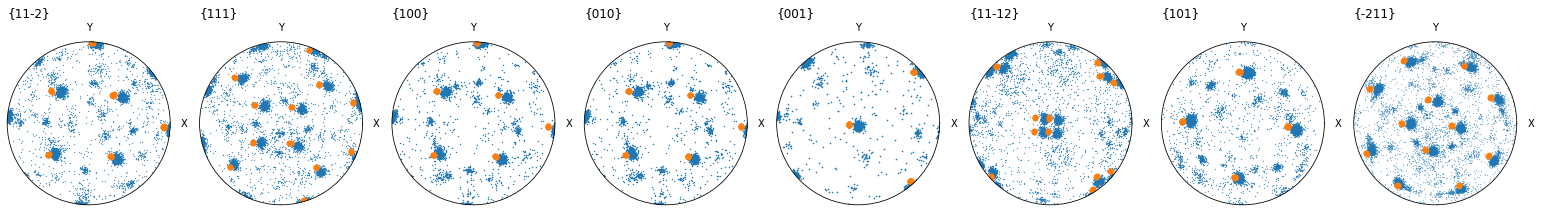

In [68]:
# Find projections of poles
proj_poles, poles_r = projections.project_crystal_poles(poles, 
#                                                eulers=eulers_m,
                                               rot_mat=rot_mat_m,
                                               crys='poly', 
                                               proj_type=proj_type, 
                                               lattice_sys='tetragonal',
                                               latt_params=latt_params_tzro2,
                                               pole_type='plane-normal', 
                                               degrees=True, axes=axes,
                                              apply_sym=True, ret_poles=True)

# angs = np.arange(300, 320, 10)
angs = [180]
for a in angs:
    rn = rotation.axang2rotmat(np.array([0,0,1]), a, degrees=True)
    rotmats = rotation.vecpair2rotmat(tettex_p, rn @ hcptex_p)[None]

    proj_poles_th_tet = projections.project_crystal_poles(poles=poles, 
                                                    rot_mat=r_met@np.array(hcp_sym_ops)[vals_true]@rotmats,    # eulers=eulers OR rot_mat=rot_mat
                                                    crys='poly', 
                                                    proj_type=proj_type,
                                                    lattice_sys=lattice_system, 
                                                    latt_params=ph_params,
                                                    pole_type=pole_type, 
                                                    degrees=True,
                                                    align=align,
                                                    apply_sym=True)

    fig = plots.plot_pole_fig(proj_poles=proj_poles, poles=poles, crys='poly',
                              lattice_sys=lattice_system, marker_size=0.01, contour=False,
                              bins=5,
                              proj_poles_theory=proj_poles_th_tet,
    #                           cols_th=colors
                             )
    print(a)
    plt.show(fig)

### Find parallel directions and closest Miller indices

In [69]:
n1124hcp = cell_rec_hcp @ lattice.miller_brav2miller(np.array([1, 1, -2, 4])[None].T)
all_Mill_n1124hcp = lattice.cart2miller_all(n1124hcp, M_hcp.T, 10,'direction', degrees_in=True, 
                                              degrees_out=True)

n111tet = cell_rec_t @ np.array([1, 1, 1])[None].T
all_Mill_n111tet = lattice.cart2miller_all(n111tet, M_tet.T, 10,'direction', degrees_in=True, 
                                              degrees_out=True)


n10tet = cell_rec_t @ np.array([1,0, 1])[None].T
all_Mill_n10tet = lattice.cart2miller_all(n10tet, M_tet.T, 10,'direction', degrees_in=True, 
                                              degrees_out=True)

n10tet = cell_rec_t @ np.array([1,1, -2])[None].T
all_Mill_n10tet = lattice.cart2miller_all(n10tet, M_tet.T, 10, 'direction',
                                          degrees_in=True, degrees_out=True)


In [70]:
print(all_Mill_n1124hcp[1][0:n])
print(np.unique(all_Mill_n1124hcp[0], axis=1)[:,0:3])

print(all_Mill_n111tet[1][0:n])
print(np.unique(all_Mill_n111tet[0], axis=1)[:,0:3])


print(all_Mill_n10tet[1][0:n])
print(np.unique(all_Mill_n10tet[0], axis=1)[:,0:3])


[0.04281884 0.3146975  0.78173119 0.98635061 1.16841753 1.77142261
 2.15426086]
[[3 4 5]
 [3 4 5]
 [1 1 1]]
[0.510425   0.65692201 0.72022678 0.84300016 1.08720014 1.39100502
 1.39100502]
[[2 3 3]
 [2 3 3]
 [1 1 2]]
[0.56895432 0.64836718 0.73685285 0.83605985 0.9002568  0.94806169
 1.05563718]
[[ 1  2  3]
 [ 1  3  2]
 [-1 -3 -3]]


### Publication figure

C:\Users\maria\anaconda3\envs\crystex_env\lib\site-packages\ipykernel_launcher.py:102: UserWarning:

FixedFormatter should only be used together with FixedLocator



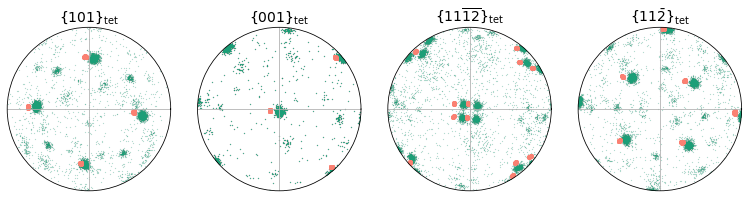

In [71]:
# code
poles_t_fig = np.array([[1,0,1],[0,0,1], [1,1,-12],[1,1,-2]]).T

# poles_t_fig = np.array([[0,0,1],[1,1,-12]]).T


# experimental
proj_poles_fig, poles_r_fig = projections.project_crystal_poles(poles_t_fig, 
#                                                eulers=eulers_m,
                                               rot_mat=rot_mat_m,
                                               crys='poly', 
                                               proj_type=proj_type, 
                                               lattice_sys='tetragonal',
                                               latt_params=latt_params_tzro2,
                                               pole_type='plane-normal', 
                                               degrees=True, axes=axes,
                                              apply_sym=True, ret_poles=True)


rn = rotation.axang2rotmat(np.array([0,0,1]), 180, degrees=True)
rotmats = rotation.vecpair2rotmat(tettex_p, rn @ hcptex_p)[None]

proj_poles_th_tet_fig = projections.project_crystal_poles(poles=poles_t_fig, 
                                                rot_mat=r_met@np.array(hcp_sym_ops)[vals_true]@rotmats,    # eulers=eulers OR rot_mat=rot_mat
                                                crys='poly', 
                                                proj_type=proj_type,
                                                lattice_sys=lattice_system, 
                                                latt_params=ph_params,
                                                pole_type='plane-normal', 
                                                degrees=True,
                                                align=align,
                                                apply_sym=True)

# Find projections of poles
rt = rotations.ax_ang2rot_mat(np.array([0,0,1]), 30, degrees=True)
r_met_min = rotations.ax_ang2rot_mat(rotations.rotmat2axang(r_met)[0],
                                     -30-np.degrees(rotations.rotmat2axang(r_met)[1]), degrees=True)

angs = [300]
for a in angs:
    rn = rotation.axang2rotmat(np.array([0,0,1]), a, degrees=True)
    rotmats = rotation.vecpair2rotmat(tettex_p, rn @ hcptex_p)[None]

    proj_poles_th_tet_fig2 = projections.project_crystal_poles(poles=poles_t_fig, 
                                                    rot_mat=r_met_min@np.array(hcp_sym_ops)[np.invert(vals_true)]@rotmats,    # eulers=eulers OR rot_mat=rot_mat
                                                    crys='poly', 
                                                    proj_type=proj_type,
                                                    lattice_sys=lattice_system, 
                                                    latt_params=ph_params,
                                                    pole_type=pole_type, 
                                                    degrees=True,
                                                    align=align,
                                                    apply_sym=True)


pole_lbl = [
    r'$\{101\}_{\mathrm{tet}}$',
    r'$\{001\}_{\mathrm{tet}}$',
    r'$\{11\overline{12}\}_{\mathrm{tet}}$',
    r'$\{11\bar{2}\}_{\mathrm{tet}}$',
           ]

fig = plot_pole_fig_paper(proj_poles=proj_poles_fig, poles=poles_t_fig,
                          lattice_sys=lattice_system, marker_size=0.001, pole_lbl=pole_lbl,
                          proj_poles_theory=[proj_poles_th_tet_fig]#[proj_poles_th_tet_fig, proj_poles_th_tet_fig2], markers=['.', 'x']
                         )
plt.show(fig)


## Monoclinic oxide $\mathrm{ZrO}_2$

### Lattice parameters

In [72]:
# -----Required parameters-----------------------------
lattice_system = 'monoclinic'
latt_params_mzro2 = [5.169, 5.232, 5.341, 90.0, 99.0, 90.0]  #a, b, c, α, β, γ

#------------------------------------------------------

params_dict_mzro2 = {
               'a': latt_params_mzro2[0],
               'b': latt_params_mzro2[1],
               'c': latt_params_mzro2[2],
               'α': latt_params_mzro2[3],
               'β': latt_params_mzro2[4],
               'γ': latt_params_mzro2[5]}
M_mon = lattice.crystal2ortho('monoclinic', **params_dict_mzro2, normed=True,
                                  degrees=True, align='cz')


mon_latt_vecs = lattice.crystal2ortho('monoclinic', **params_dict_mzro2, normed=False,
                                  degrees=True, align='cz').T
cell_e = np.eye(3)
cell_ortho_mon = np.dot(M_mon.T, cell_e)
cell_rec_mon = lattice.reciprocal_lattice_vecs(cell_ortho_mon)

### Load experimental data

In [73]:
# USER INPUT: Input file path-------------------------------------------------
home_path = './data/'
file_path = 'EBSD_oxide_region_1.ctf'

# ----------------------------------------------------------------------------

tw = widgets.ToggleButtons(
    description='Technique:',
    options=['ASTAR', 'EBSD'],
)
display(tw)


ToggleButtons(description='Technique:', options=('ASTAR', 'EBSD'), value='ASTAR')

In [74]:
# Read data
header = fileutils.read_ctf_header(os.path.join(home_path, file_path), )
n_ph = header['no_phases']

data = pd.read_csv(os.path.join(home_path, file_path), sep='\t', header=13 + n_ph).values

XCells = header['XCells']
YCells = header['YCells']
num_pix = XCells * YCells

idx_rows = np.tile(np.arange(XCells), YCells)
idx_cols = np.repeat(np.arange(YCells), XCells)

phases = data[:,0].astype(int)
phases -= 1
euler_angles = data[:,5:8]
mad = data[:,8]
bc = data[:,9]
bs = data[:,10]

phase_map = phases.reshape((XCells,YCells), order = 'F')

eul_map = euler_angles.reshape((XCells,YCells, 3), order = 'F')
eul_map_norm = np.copy(eul_map)
eul_map_norm[:,:,0] /= 360.0
eul_map_norm[:,:,1] /= 180.0
eul_map_norm[:,:,2] = coordgeometry.wrap_angles(eul_map_norm[:,:,2], 0.0, 360.0)
eul_map_norm[:,:,2] /= 360.0

mad_map = mad.reshape((XCells,YCells), order = 'F')
bc_map = bc.reshape((XCells,YCells), order = 'F')
bs_map = bs.reshape((XCells,YCells), order = 'F')

# Map options based on technique
map_opt = ['phases','euler angles']
tech = tw.value # technique type
if tech == 'EBSD':
    map_opt.append('mean angular deviation')
    map_opt.append('band contrast')
else:
    map_opt.append('reliability factor')
    map_opt.append('intensity')

In [75]:
print('Total number of pixels: ', num_pix)
print(header['phases'][0]['name'], np.sum(phases == 0))
print(header['phases'][1]['name'], np.sum(phases == 1))
print(header['phases'][2]['name'], np.sum(phases == 2))
print('Non-indexed', np.sum(phases == -1))

Total number of pixels:  558700
Zirconia tetragonal 1847
Zirc-alloy4 1353
Zr02 monoclinic 49938
Non-indexed 505562


### Plot experimental pole figures

In [76]:
ph_opt = [x['name'] for x in header['phases']]
all_ph_ind = [index+1 for index, value in enumerate(ph_opt)]

style = {'description_width': 'initial'}
w = widgets.RadioButtons(
    description='Choose a phase',
    options=ph_opt,
    layout=ipywidgets.Layout(width='100%', height='80px'),
    style=style,
    index=2
)
display(w)

RadioButtons(description='Choose a phase', index=2, layout=Layout(height='80px', width='100%'), options=('Zirc…

In [77]:
# Phase index, name and lattice parameters
ph_ind = ph_opt.index(w.value)
ph_name = w.value
ph_params = header['phases'][ph_ind]['lattice_params']

# Create masks to be used for plotting the right data
mask_1d = phases != ph_ind
mask_2d = np.repeat(mask_1d[:,np.newaxis], 2, axis=1)
mask_3d = np.repeat(mask_1d[:,np.newaxis], 3, axis=1)

print('Chosen phase: ')
print(header['phases'][ph_ind])

Chosen phase: 
{'name': 'Zr02 monoclinic', 'lattice_params': [5.1461, 5.2118, 5.313, 90.0, 99.22, 90.0]}


In [78]:
# USER INPUT: Pole figure options---------------------------------------------
lattice_system = 'monoclinic'
poles = np.array([[1,0,-1],[2,0,1],[1,-1,0],[1,1,0], [1,0,-6],[0,0,1],[1,1,1],[1,1,-1] ]).T
proj_type = 'equal_area'   # 'stereographic' or 'equal_area'
plot_contour = False        # True or False
axes = 'xyz'                # 'xyz' (default); 'yzx'; 'zxy'; 'yxz'; 'zyx'; 'xzy'
# ----------------------------------------------------------------------------



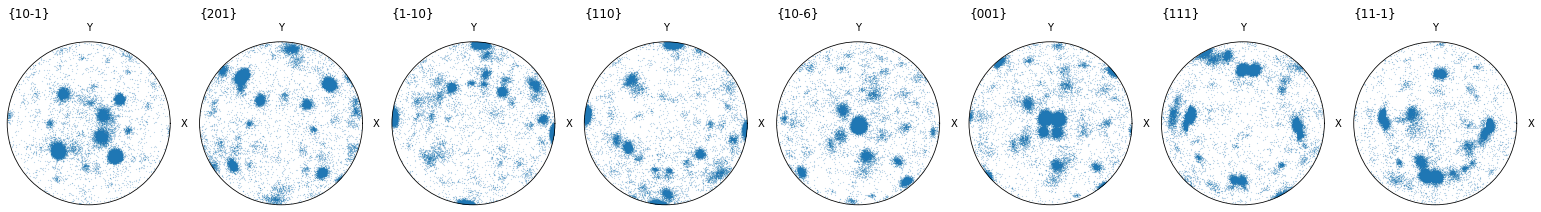

In [79]:
# code
eulers_m = np.ma.compress_rowcols(np.ma.array(euler_angles, 
                                              mask=mask_3d), 0)
rot_mat_m = np.linalg.inv(
                rotations.euler2rot_mat_n(eulers_m, degrees=True))


# Find projections of poles
proj_poles = projections.project_crystal_poles(poles, 
                                               eulers=eulers_m,
#                                                rot_mat=rot_mat_m,
                                               crys='poly', 
                                               proj_type=proj_type, 
                                               lattice_sys=lattice_system, 
                                               latt_params=ph_params,
                                               pole_type='plane-normal', 
                                               degrees=True, axes=axes,
                                              apply_sym=False)

    
# Plot pole figures
fig = plots.plot_pole_fig(proj_poles, poles=poles, 
                          lattice_sys=lattice_system, crys='poly', axes=axes, 
                          contour=False, bins = 20, marker_size=0.01)

plt.show(fig)


### Publication figure

C:\Users\maria\anaconda3\envs\crystex_env\lib\site-packages\ipykernel_launcher.py:102: UserWarning:

FixedFormatter should only be used together with FixedLocator



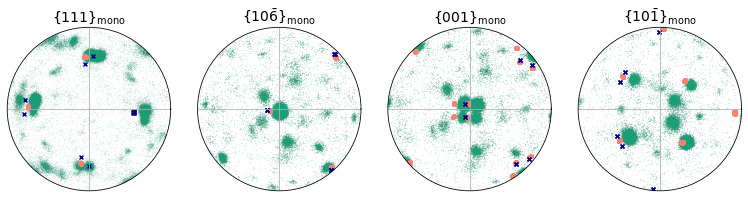

In [80]:
# tehsis paper fig
poles_m_fig = np.array([[1,1,1],[1,0,-6], [0,0,1],[1,0,-1]]).T
# {111}, {201}, {10-6}, {001}, {10-1}, 

# experimental
proj_poles_fig, poles_r_fig = projections.project_crystal_poles(poles_m_fig, 
                                               rot_mat=rot_mat_m,
                                               crys='poly', 
                                               proj_type=proj_type, 
                                               lattice_sys='monoclinic',
                                               latt_params=latt_params_mzro2,
                                               pole_type='plane-normal', 
                                               degrees=True, axes=axes,
                                              apply_sym=True, ret_poles=True)
montex = np.array([[1, 1, 1]]).T
montex_p = cell_rec_mon @ montex
hcptex = lattice.miller_brav2miller(np.array([0,0,0,1])[None].T)
hcptex_ortho = np.dot(M_hcp.T, hcptex)
rn = rotation.axang2rotmat(np.array([0,0,1]), 20, degrees=True)
rotmats = rotation.vecpair2rotmat(montex_p, hcptex_ortho)[None]
proj_poles_th_m = projections.project_crystal_poles(poles=poles_m_fig, 
                                                    rot_mat= r_met@np.array(hcp_sym_ops)[vals_true] @ rn @ rotmats,    # eulers=eulers OR rot_mat=rot_mat
                                                    crys='poly', 
                                                    proj_type=proj_type,
                                                    lattice_sys='monoclinic', 
                                                    latt_params=latt_params_mzro2,
                                                    pole_type=pole_type, 
                                                    degrees=True,
                                                    align=align,
                                                    apply_sym=True)

pole_lbl = [r'$\{111\}_{\mathrm{mono}}$',
            r'$\{10\bar{6}\}_{\mathrm{mono}}$',
            r'$\{001\}_{\mathrm{mono}}$',
            r'$\{10\bar{1}\}_{\mathrm{mono}}$',
           ]


fig = plot_pole_fig_paper(proj_poles=proj_poles_fig, poles=poles_m_fig,
                          lattice_sys=lattice_system, marker_size=0.001, pole_lbl=pole_lbl,
                          proj_poles_theory=[proj_poles_th_tet_fig,proj_poles_th_m], markers=['o', 'x']
                         )
plt.show(fig)



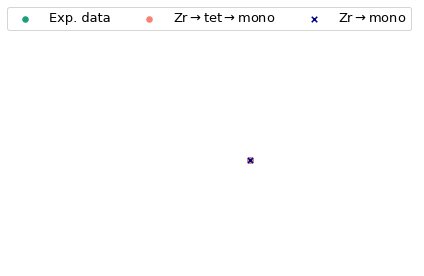

In [81]:
m = ['o', 'x']
cls = ['salmon',  'darkblue']
ax = plt.subplot() 
ax.scatter(1,1, c='#1b9e77', marker=m[0],label='Exp. data',s=30,)
ax.scatter(1,1, c=cls[0], marker=m[0], label=r'Zr$\rightarrow$tet$\rightarrow$mono',s=30,)
ax.scatter(1,1, c=cls[1], marker=m[1],label=r'Zr$\rightarrow$mono', s=30,)
ax.set_axis_off()  
ax.legend( fontsize=13, ncol=3, loc=5, bbox_to_anchor=(0., 1.1, 1., .102), borderaxespad=0.5)

